<a href="https://colab.research.google.com/github/JamesAllingham/DFL-WGAN/blob/master/DFL_WGAN_week2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lets load the data and have a look:

In [0]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt

In [2]:
iris, _ = load_iris(return_X_y=True)
print(iris.shape)
df = pd.DataFrame(iris)
df.columns = ['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width']
df[0:20]

(150, 4)


,Sepal Length,Sepal Width,Petal Length,Petal Width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
5,5.4,3.9,1.7,0.4
6,4.6,3.4,1.4,0.3
7,5.0,3.4,1.5,0.2
8,4.4,2.9,1.4,0.2
9,4.9,3.1,1.5,0.1


Lets visualize two if the dimmensions of our data:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


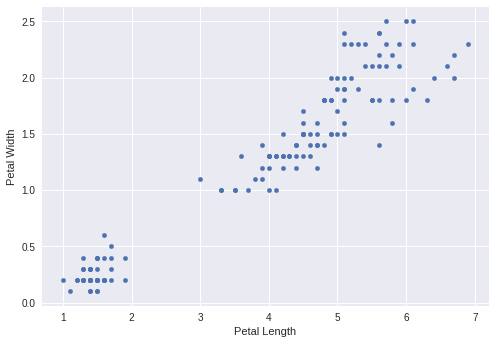

In [3]:
df.plot.scatter(x="Petal Length", y="Petal Width")

Now lets fit a multivariate gaussian. 

A (multivariate) gaussian has two paramters: it's mean vector  **μ** and its covariance matrix **Σ**.

The maximum likelihood estimates of these parameters can be calculated using to following formulae (courtesy PRML section 2.3.4):

\begin{equation}
\mathbf{μ_{ml}} = \frac{1}{N}\sum_{n=1}^N\mathbf{x_n}
\end{equation}

\begin{equation}
\mathbf{Σ_{ml}} = \frac{1}{N - 1}\sum_{n=1}^N(\mathbf{x_n} - \mathbf{μ_{ml}})(\mathbf{x_n} - \mathbf{μ_{ml}})^T
\end{equation}

(okay the formula for $\mathbf{Σ_{ml}}$ should divide by $N$ for MLE but that is a biased estimate so we do $N - 1$ in practice.)

So lets implement these:

In [4]:
μ_ml = np.mean(iris,axis=0)
μ_ml

array([5.84333333, 3.05733333, 3.758     , 1.19933333])

In [5]:
Σ_ml = np.dot((iris - μ_ml).T, iris - μ_ml)/(iris.shape[0] - 1)
Σ_ml

array([[ 0.68569351, -0.042434  ,  1.27431544,  0.51627069],
       [-0.042434  ,  0.18997942, -0.32965638, -0.12163937],
       [ 1.27431544, -0.32965638,  3.11627785,  1.2956094 ],
       [ 0.51627069, -0.12163937,  1.2956094 ,  0.58100626]])

Now that we we have the parameters of our multivariate Gaussian we can ask questions about the probability of seeing various iris flowers and we can even generate new flowers. 

Lets figure out the probability of seeing a flower with  a sepal length of 7.9, a sepal width of 4.4, a petal length of 6.9, and a petal width of 2.5:

In [0]:
from scipy.stats import multivariate_normal

In [7]:
multivariate_normal.pdf(x=[7.9, 4.4, 6.9, 2.5], mean=μ_ml, cov=Σ_ml)

5.724602136097143e-06

That is quite low, but this is because our test point is far from the mean, if we wanted to know the probability of the `mean` flower we get a much higher value:

In [8]:
multivariate_normal.pdf(x=μ_ml, mean=μ_ml, cov=Σ_ml)

0.5791798794013171

Now lets as a more complicated question: what is the probability distribution of flowers with a sepal length of 6.3, a sepal width of 4.8, and a petal length of 6.0?

For this we can use the following formula (courtesy PRML section 2.3.2):

\begin{equation}
p(\mathbf{x_a}|\mathbf{x_b}) = \mathcal{N}(\mathbf{x}|\mathbf{μ_{a|b}},\mathbf{A}^{-1}_{aa})
\end{equation}

where $\mathbf{Λ} =\begin{bmatrix} \mathbf{Λ_{aa}} & \mathbf{Λ_{ab}} \\ \mathbf{Λ_{ba}} & \mathbf{Λ_{bb}} \end{bmatrix} = \mathbf{Σ}^{-1}$ is the precision matrix, $\mathbf{μ_{a|b}} = \mathbf{μ_{a}} - \mathbf{Λ_{aa}}^{-1}\mathbf{Λ_{ab}}(\mathbf{x_b} - \mathbf{μ_b})$, and $\mathbf{μ} = [\mathbf{μ_a}~ \mathbf{μ_b}]$.



In [9]:
Λ = np.linalg.inv(Σ_ml)
Λ

array([[ 10.31469875,  -6.71318923,  -7.31448253,   5.739951  ],
       [ -6.71318923,  11.05841725,   6.48058913,  -6.17093237],
       [ -7.31448253,   6.48058913,  10.03167858, -14.5137665 ],
       [  5.739951  ,  -6.17093237, -14.5137665 ,  27.69363502]])

In [10]:
μ_ab = μ_ml[3] - Λ[3,3]**(-1)*np.dot(Λ[0:3,3],(np.array([6.3, 4.8, 6.0]) - μ_ml[0:3]))
μ_ab

2.6679920454189805

Now that we have $μ_{ab}$ and can easily calculate $A^{−1}_{aa}$ lets visualize our conditional distribution:


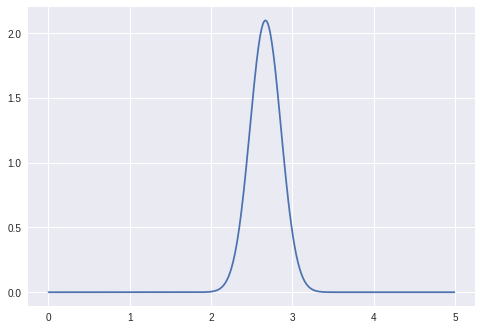

In [11]:
xvals = np.arange(0,5,0.01)
yvals = multivariate_normal.pdf(x=xvals, mean=μ_ab, cov=Λ[3,3]**(-1))
plt.plot(xvals, yvals)
plt.show()

Now lets use our model to generate some new data! Lets generate 20 iris flowers:

In [12]:
df = pd.DataFrame(multivariate_normal.rvs(mean=μ_ml, cov=Σ_ml, size=100))
df.columns = ['Sepal Length', 'Sepal Width', 'Petal Length', 'Petal Width']
df[0:20]

,Sepal Length,Sepal Width,Petal Length,Petal Width
0,6.118625,2.570857,4.184754,1.287985
1,5.497098,2.785615,1.434449,-0.155940
2,7.037165,3.229700,4.998909,1.617966
3,6.502299,3.344393,5.077397,1.545345
4,7.980463,3.054256,7.832054,2.845207
5,5.856393,2.603786,4.534879,1.568071
6,6.006947,2.433683,5.153938,1.514918
7,6.187213,3.172275,4.260303,1.603662
8,5.387855,3.543518,2.674963,0.928532
9,6.153542,4.217961,2.269350,0.533885


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


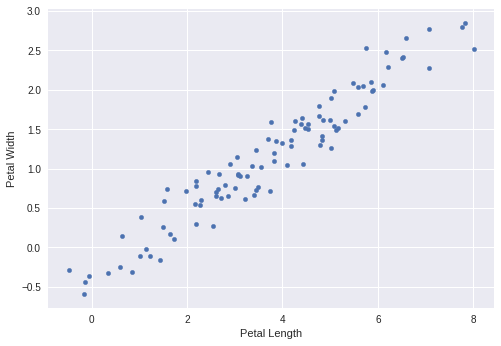

In [13]:
df.plot.scatter(x="Petal Length", y="Petal Width")

And finaly, lets get a little more fancy and generate flowers with sepal lengths of 6.3 cm. We'll use the same formulae for conditional Gaussians as before:

In [14]:
μ_ab = μ_ml[1:4] - np.dot(np.linalg.inv(Λ[1:4,1:4]),Λ[1:4,0]*(np.array([6.3]) - μ_ml[0]))
μ_ab

array([3.02907261, 4.60668439, 1.54316569])

In [15]:
df = pd.DataFrame(multivariate_normal.rvs(mean=μ_ab, cov=np.linalg.inv(Λ[1:4,1:4]), size=100))
df.columns = ['Sepal Width', 'Petal Length', 'Petal Width']
df[0:20]

,Sepal Width,Petal Length,Petal Width
0,2.711183,5.972142,2.264218
1,2.359277,4.991391,1.853236
2,3.176533,4.893818,1.616926
3,3.043512,4.743595,1.511776
4,2.547686,4.606161,1.091952
5,2.488950,4.824127,1.525447
6,2.408906,4.744851,1.354360
7,2.826068,5.616797,1.878519
8,2.847450,6.052265,1.932640
9,2.835757,5.864965,2.314502


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


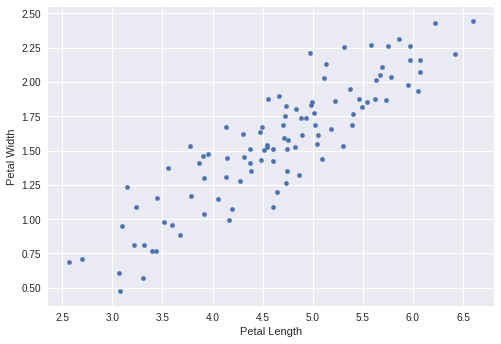

In [16]:
df.plot.scatter(x="Petal Length", y="Petal Width")